In [1]:
import sys
import datacube
import numpy as np
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

sys.path.append('../../Scripts')
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_dask import create_local_dask_cluster
from dea_plotting import xr_animation
from dea_coastaltools import tidal_tag

dc = datacube.Datacube(app='Animated tides')

%load_ext autoreload
%autoreload 2

In [14]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geopolygon = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4) 

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [15]:
bands=['nbar_red', 'nbar_green', 'nbar_blue']
# bands=['nbar_swir_1', 'nbar_nir', 'nbar_green']

# Configure local dask cluster
create_local_dask_cluster()

# Obtain native CRS 
crs = mostcommon_crs(dc=dc, 
                     product='ga_ls5t_ard_3', 
                     query={'time': '1990', 
                            'geopolygon': geopolygon})

# Standard Landsat
query = {
    'geopolygon': geopolygon,
    'time': ('1987', '2020'),
    'measurements': bands,
    'resampling': {'fmask': 'nearest', 
                   'oa_fmask': 'nearest', 
                   '*': 'nearest'},
    'output_crs': crs,
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {'time': 1, 'x': 1000, 'y': 1000}
}

# # Landsat upscaled res
# query = {
#     'geopolygon': geopolygon,
#     'time': ('1986', '2020'),
#     'measurements': bands,
#     'resampling': {'fmask': 'nearest', 
#                    'oa_fmask': 'nearest', 
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-15, 15),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}
# }

# # Sentinel-2 10m
# crs = mostcommon_crs(dc=dc, 
#                      product='s2a_ard_granule', 
#                      query={'time': '2018', 
#                             'geopolygon': geopolygon})

# query = {
#     'geopolygon': geopolygon,
#     'time': ('2016', '2020'),
#     'measurements': bands,
#     'resampling': {'fmask': 'nearest', 
#                    'oa_fmask': 'nearest', 
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-10, 10),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}
# }

ds_tides = load_ard(dc=dc,
                 products=[
                           'ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3', 
#                            's2a_ard_granule', 's2a_ard_granule'
                          ],
                 min_gooddata=0.90,
                 ls7_slc_off=False,
                 mask_pixel_quality=True,
                 **query)

# Load data into memory
ds_tides = ds_tides.compute()
ds_tides




/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39346 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:33384 Dashboard: /proxy/39346/status,Cluster Workers: 1 Cores: 8 Memory: 30.67 GB


../../Scripts/dea_datahandling.py:286: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 379 out of 1200 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 379 time steps as a dask array


<xarray.Dataset>
Dimensions:      (time: 379, x: 666, y: 548)
Coordinates:
  * x            (x) float64 4.06e+05 4.06e+05 4.06e+05 ... 4.259e+05 4.259e+05
  * time         (time) datetime64[ns] 1987-05-26T01:13:36.377192 ... 2020-04...
  * y            (y) float64 -2.001e+06 -2.001e+06 ... -2.018e+06 -2.018e+06
    spatial_ref  int32 32651
Data variables:
    nbar_red     (time, y, x) float32 nan nan nan nan ... 769.0 774.0 753.0
    nbar_green   (time, y, x) float32 nan nan nan nan ... 623.0 629.0 624.0
    nbar_blue    (time, y, x) float32 nan nan nan nan ... 434.0 436.0 430.0
Attributes:
    crs:           epsg:32651
    grid_mapping:  spatial_ref

## Tidal modelling

In [16]:
ds_tides = tidal_tag(ds_tides, ebb_flow=True, swap_dims=True)

Setting tide modelling location from dataset centroid: 122.21, -18.17
Modelling tidal phase (e.g. ebb or flow)


In [17]:
# Extract ebb and flow stages as different datasets
filtered_flow = ds_tides.where(ds_tides.ebb_flow == 'Flow', drop = True)
filtered_ebb = ds_tides.where(ds_tides.ebb_flow == 'Ebb', drop = True)

In [18]:
# Sort flow by increasing tide height, and ebb by decreasing
filtered_flow = filtered_flow.sortby('tide_height')
filtered_ebb = filtered_ebb.sortby('tide_height', ascending=False)

In [21]:
window = 50

# Extract end of ebb and start of flow
end_of_flow = filtered_flow.isel(tide_height=slice(-(window // 2)-5, -1))
start_of_ebb = filtered_ebb.isel(tide_height=slice(0, 5+(window // 2)))

# Combine into a single array and take rolling median
import xarray as xr
ds_concat = xr.concat([end_of_flow, filtered_ebb, 
                       filtered_flow, start_of_ebb], dim='tide_height')

ds_rolling = (ds_concat
              .drop('ebb_flow')
              .rolling(tide_height=window, center=True, min_periods=1)
              .median())

# Restore ebb-flow data and drop out buffered ends of tide series
ds_rolling['ebb_flow'] = ds_concat['ebb_flow']       
ds_rolling = ds_rolling.isel(tide_height=slice(5+(window // 2), -(window // 2)-5))

# Add random noise to tide heights to avoid indexing issues
ds_rolling['tide_height'] = ds_rolling['tide_height'] + (np.random.random(len(ds_rolling.tide_height)) - 0.5) / 100

In [22]:
# ndwi = (ds_rolling.nbar_green - ds_rolling.nbar_nir) / (ds_rolling.nbar_green + ds_rolling.nbar_nir)
# ndwi_rescaled = (10-(ndwi+1)/2)/10

In [23]:
# ds_rolling[['nbar_red', 'nbar_green', 'nbar_blue']] = ds_rolling[['nbar_red', 'nbar_green', 'nbar_blue']] * ndwi_rescaled

In [24]:
# test = ds_rolling[['nbar_red', 'nbar_green', 'nbar_blue']] * ndwi_rescaled

In [25]:
# Extract ebb and flow stages as different datasets
filtered_flow = ds_rolling.where(ds_rolling.ebb_flow == 'Flow', drop = True)
filtered_ebb = ds_rolling.where(ds_rolling.ebb_flow == 'Ebb', drop = True)

# Interpolate even number of frames for ebb and flow tides
import numpy as np
int_bins = np.linspace(filtered_flow.tide_height.min(), 
                       filtered_flow.tide_height.max(), 75)
ds_interp_flow = filtered_flow.interp(tide_height=int_bins)

int_bins = np.linspace(filtered_ebb.tide_height.max(), 
                       filtered_ebb.tide_height.min(), 75)
ds_interp_ebb = filtered_ebb.interp(tide_height=int_bins)

# Finally combine all frames
ds_interp = xr.concat([ds_interp_ebb, ds_interp_flow], dim='tide_height')

In [26]:
ebb_flow_text = len(ds_interp_ebb.tide_height) * ['Ebb tide'] + len(ds_interp_flow.tide_height) * ['Flow tide']
tide_text = [f'{a}\n{b:0.2f} m' for a, b in zip(ebb_flow_text, ds_interp.tide_height.values)]

Applying custom image processing functions


Exporting animation to animated_tides_roebuck.mp4


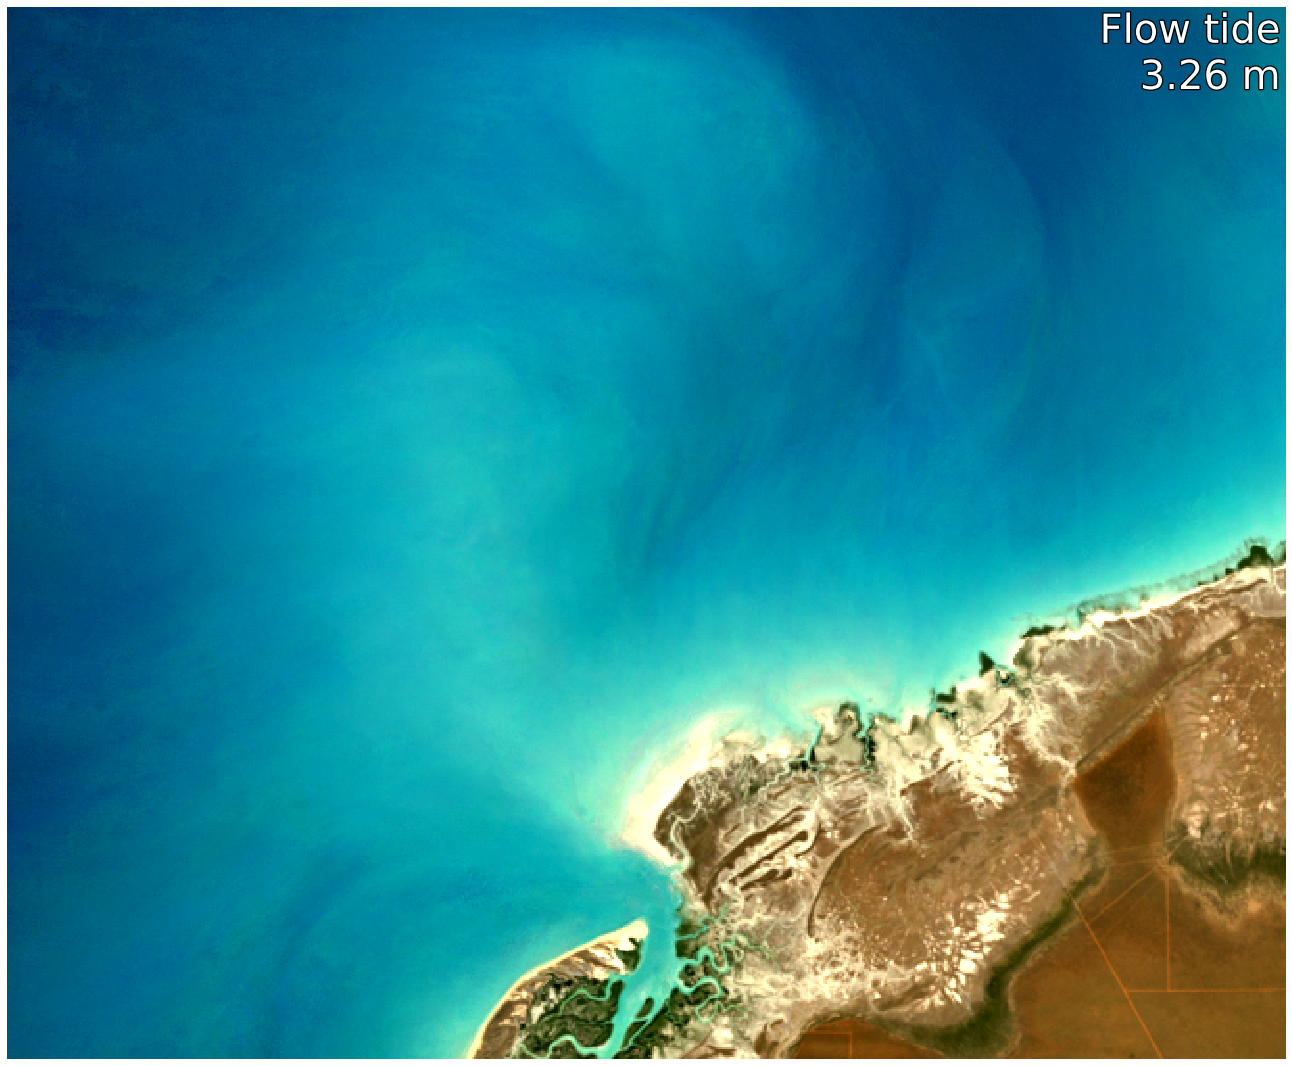

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/multiprocessing/semaphore_tracker.py:55: UserWarning: semaphore_tracker: process died unexpectedly, relaunching.  Some semaphores might leak.
  warnings.warn('semaphore_tracker: process died unexpectedly, '
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [27]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

funcs_list = [
#               lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
              lambda x: x**0.5,
              rescale_intensity,
#               hue_sat_val,
              lambda x: unsharp_mask(x, radius=50, amount=0.5),
              lambda x: unsharp_mask(x, radius=5, amount=0.3),
#               lambda x: adjust_sigmoid(image=x, cutoff=0.5, gain=0.5),
             ]
# funcs_list = None

xr_animation(ds=ds_interp.rename({'tide_height': 'time'}),
             output_path='animated_tides_roebuck.mp4',
             bands=bands[0:3],
             interval=30,
             width_pixels=1280,
             percentile_stretch=(0.01, 0.99),
             image_proc_funcs=funcs_list,
             show_date=False,
             show_text=tide_text,
             annotation_kwargs={'fontsize': 40},
#              limit=10
            ) 

In [ ]:
!ffprobe animated_tides2.mp4

In [ ]:
import gc
gc.collect()

In [ ]:
# Create copy and set time to time
data_tide = data.copy(deep=True)
data_tide['time'] = data_tide['tide_heights']
data_tide.rename({'time': 'tide'}, inplace=True)

# Extract ebb and flow stages as different datasets
filtered_flow = data_tide.where(data_tide.tide_phase == 'Flow', drop = True)
filtered_ebb = data_tide.where(data_tide.tide_phase == 'Ebb', drop = True)

# Sort flow by increasing tide height, and ebb by decreasing
filtered_flow = filtered_flow.sortby('tide')
filtered_ebb = filtered_ebb.sortby('tide', ascending=False)

# Drop categorical labels to allow rolling window
print(filtered_flow)
print(filtered_ebb)


In [ ]:
ds_rolling = ds_ls.rolling(time=40, center=True, min_periods=1).median()
median_array = np.transpose(ds_rolling[bands]
                            .median(dim='time')
                            .to_array().values, 
                            axes=(1, 2, 0))
print(ds_rolling)

## DEA CoastLines data

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib

# Get bounding box of data
xmin, ymin, xmax, ymax = ds_ls.geobox.geographic_extent.boundingbox

# Set up WFS requests for annual coastlines & rates of change statistics
deacl_coastlines_wfs = 'https://nonprod.geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:coastlines&maxFeatures=1000&' \
                      f'bbox={ymin},{xmin},{ymax},{xmax},urn:ogc:def:crs:EPSG:4326'

# Load data from WFS and set CRS
deacl_gdf = gpd.read_file(deacl_coastlines_wfs)
deacl_gdf.crs = 'EPSG:3577'

# Clip to extent of satellite data
bbox = gpd.GeoDataFrame(geometry=[ds_ls.geobox.extent.geom],
                        crs=ds_ls.geobox.crs)  
deacl_gdf = gpd.overlay(deacl_gdf, bbox.to_crs(deacl_gdf.crs))
deacl_gdf = deacl_gdf.dissolve('year')

# Apply colours
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(deacl_gdf.index))
cmap = matplotlib.cm.get_cmap('inferno')
rgba = cmap(norm(deacl_gdf.reset_index().index))
deacl_gdf['color'] = list(rgba)
deacl_gdf['start_time'] = (pd.to_datetime(deacl_gdf.index) + 
                           pd.DateOffset(months=5))

# Remove a year
# deacl_gdf = deacl_gdf.drop('1993')

deacl_gdf.plot()

## Run animation

In [ ]:
from skimage.color import rgb2hsv, hsv2rgb

def hue_sat_val(rgb_array,
                hue_mult=1, 
                sat_mult=0.8, 
                val_mult=1):   
    
    # Convert to HSV and multiply bands
    hsv_array = rgb2hsv(rgb_array)
    hsv_array[:, :, 0] = hsv_array[:, :, 0] * hue_mult
    hsv_array[:, :, 1] = hsv_array[:, :, 1] * sat_mult
    hsv_array[:, :, 2] = hsv_array[:, :, 2] * val_mult
    
    # Convert back to RGB
    return hsv2rgb(hsv_array.clip(0, 1))



In [ ]:
import geopandas as gpd

# Specify bounding box
ymax, xmin = -33.6507, 115.2790
ymin, xmax = -33.6585, 115.3013

# Set up WFS requests for annual coastlines & rates of change statistics
deacl_coastlines_wfs = 'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:coastlines&srsName=EPSG%3A3577&' \
                       f'maxFeatures=1000&bbox={ymin},{xmin},{ymax},{xmax}'
deacl_statistics_wfs = 'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:coastlines_statistics&' \
                       'srsName=EPSG%3A3577&maxFeatures=1000&' \
                       f'bbox={ymin},{xmin},{ymax},{xmax}'

# Load DEA CoastLines data from WFS using geopandas
deacl_coastlines_gdf = gpd.read_file(deacl_coastlines_wfs)
deacl_statistics_gdf = gpd.read_file(deacl_statistics_wfs)

# Ensure CRSs are set correctly
deacl_coastlines_gdf.crs = 'EPSG:3577'
deacl_statistics_gdf.crs = 'EPSG:3577'